In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
%matplotlib inline

In [2]:
base_dir = "C:/Users/joanc/PycharmProjects/face_detection/"

In [3]:
def plot_single_img(img):
    if len(img.shape) == 2:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)

In [72]:
def slide_window(img, window_size=36):
    h, w, _ = img.shape
    for i in range(0, h-window_size, window_size//2):
        for j in range(0, w-window_size, window_size//2):
            yield img[i:i+window_size, j:j+window_size], i, j

def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()


img = np.array(Image.open("Mixed-Raced-family-e1513084049363-600x320.jpg"))

(384, 720, 3)


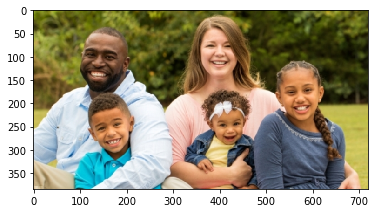

In [73]:
def zoom(img, factor=1.2):
    return cv2.resize(img, dsize=None,fx=factor, fy=factor)

zoomed = zoom(img)
print(zoomed.shape)
plot_single_img(zoomed)

In [6]:
# bugg fix for some computers
# it makes tensorflow use only the part of the gpu that is needed
gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

In [39]:
model = load_model("saved_models/face_classifier_color.h5")
window_size = 64
new_img = cv2.imread("Mixed-Raced-family-e1513084049363-600x320.jpg")
new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
print(new_img.shape)
# new_img = cv2.resize(new_img, None, fx=0.5, fy=0.5)

(320, 600, 3)


In [40]:
def slide_window(img, window_size=window_size, batch_size=64, stride=5):
    h, w, _ = img.shape
    batch = np.zeros((batch_size, window_size, window_size, 3))
    count = 0
    for i in range(0, h-window_size, stride):
        for j in range(0, w-window_size, stride):
            batch[count] = img[i:i+window_size, j:j+window_size]
            count += 1
            if count == batch_size:
                count = 0
                yield batch
    yield batch[:count]

def calculate_bounding_box(y, x, original_shape, actual_shape, window_size):
    scale = original_shape[0] / actual_shape[0], original_shape[1] / actual_shape[1]
    size_bb = int(window_size*scale[0])
    return [int(y*scale[0]), int(x*scale[1]), int(y*scale[0])+size_bb, int(x*scale[1])+size_bb]
    
def bounding_boxes(img, window_size, stride, original_shape):
    h, w, _ = img.shape
    for i in range(0, h-window_size, stride):
        for j in range(0, w-window_size, stride):
            yield calculate_bounding_box(i, j, original_shape, img.shape[:2], window_size) 
            
# gen = slide_window(new_img.reshape(*new_img.shape, 1), stride=2)

In [41]:
from math import ceil
def calculate_nb_steps(img_shape, window_size, stride, batch_size):
    return ceil(ceil((img_shape[0] - window_size) / stride) * ceil((img_shape[1] - window_size) / stride) / batch_size)

def predict_pyramid(model, img, threshold=0.5, zoom_factor=1.2, zoom_iterations=3, unzoom_factor=0.7,
                    window_size=36, batch_size=128, stride=5):
    img = img / 255
    original_shape = img.shape
    boxes = []
    # zooming
    for it in range(zoom_iterations):
        generator = slide_window(img, window_size=window_size, stride=stride, batch_size=batch_size)
        nb_steps = calculate_nb_steps(img.shape, window_size, stride, batch_size)
        probabilities = model.predict_generator(generator, steps=nb_steps, workers=0)
        bounding_boxes_gen = bounding_boxes(img, window_size=window_size, 
                                            stride=stride, original_shape=original_shape)
        for it in range(len(probabilities)):
            box = next(bounding_boxes_gen)
            box.append(probabilities[it][0])
            boxes.append(box)
        img = zoom(img, zoom_factor)
    
    # unzooming
    img = cv2.resize(img, (original_shape[1], original_shape[2]))
    img = zoom(img, unzoom_factor)
    while img.shape[0] > window_size and img.shape[1] > window_size:
        generator = slide_window(img, window_size=window_size, stride=stride, batch_size=batch_size)
        nb_steps = calculate_nb_steps(img.shape, window_size, stride, batch_size)
        probabilities = model.predict_generator(generator, steps=nb_steps, workers=0)
        bounding_boxes_gen = bounding_boxes(img, window_size=window_size, 
                                            stride=stride, original_shape=original_shape)
        for it in range(len(probabilities)):
            box = next(bounding_boxes_gen)
            box.append(probabilities[it][0])
            boxes.append(box)
        
        img = zoom(img, unzoom_factor)
        
        
    
    return np.array(boxes)
        
boxes =  np.array(predict_pyramid(model, new_img, stride=18, batch_size=64, window_size=window_size))
print(len(boxes))

2151


In [42]:
print(new_img.shape)

(320, 600, 3)


In [43]:
print(boxes[:5])

[[0.00000000e+00 0.00000000e+00 6.40000000e+01 6.40000000e+01
  0.00000000e+00]
 [0.00000000e+00 1.80000000e+01 6.40000000e+01 8.20000000e+01
  3.57627869e-07]
 [0.00000000e+00 3.60000000e+01 6.40000000e+01 1.00000000e+02
  3.57627869e-07]
 [0.00000000e+00 5.40000000e+01 6.40000000e+01 1.18000000e+02
  2.02655792e-06]
 [0.00000000e+00 7.20000000e+01 6.40000000e+01 1.36000000e+02
  3.15904617e-05]]


(320, 600, 3)


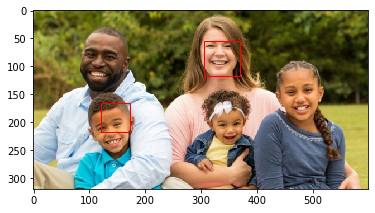

In [45]:
from matplotlib.patches import Rectangle
print(new_img.shape)
def plot_img_with_bb(img, boxes):
    plot_img = img
    plt.imshow(plot_img, )

    # Add the patch to the Axes
    for y1, x1, y2, x2  in boxes:
        plt.gca().add_patch(Rectangle((x1,y1), x2-x1, y2-y1, linewidth=1,edgecolor='r',facecolor='none'))

threshold = 0.9
plot_img_with_bb(new_img, boxes[boxes[:,4] > threshold][:,:4])

In [46]:
def non_max_suppression_fast(boxes, overlapThresh):
    """
    https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
    """
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    # initialize the list of picked indexes    
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
 
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
 
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
 
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
 
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")


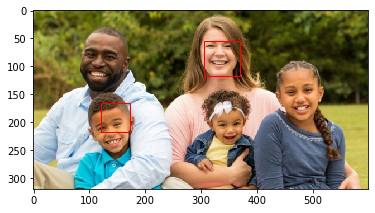

In [47]:
boxes_supressed = non_max_suppression_fast(boxes[boxes[:,4] > threshold][:,:4], 0.3)
plot_img_with_bb(new_img, boxes_supressed)

## Benchmark
Predicting bounding boxes in WIDER face dataset http://shuoyang1213.me/WIDERFACE/index.html
### Submission instructions

In [48]:
s

NameError: name 's' is not defined

In [16]:
val_dataset_path = "dataset/WIDER_test/images/"

In [17]:
from os import listdir

print(listdir(val_dataset_path))

['0--Parade', '1--Handshaking', '10--People_Marching', '11--Meeting', '12--Group', '13--Interview', '14--Traffic', '15--Stock_Market', '16--Award_Ceremony', '17--Ceremony', '18--Concerts', '19--Couple', '2--Demonstration', '20--Family_Group', '21--Festival', '22--Picnic', '23--Shoppers', '24--Soldier_Firing', '25--Soldier_Patrol', '26--Soldier_Drilling', '27--Spa', '28--Sports_Fan', '29--Students_Schoolkids', '3--Riot', '30--Surgeons', '31--Waiter_Waitress', '32--Worker_Laborer', '33--Running', '34--Baseball', '35--Basketball', '36--Football', '37--Soccer', '38--Tennis', '39--Ice_Skating', '4--Dancing', '40--Gymnastics', '41--Swimming', '42--Car_Racing', '43--Row_Boat', '44--Aerobics', '45--Balloonist', '46--Jockey', '47--Matador_Bullfighter', '48--Parachutist_Paratrooper', '49--Greeting', '5--Car_Accident', '50--Celebration_Or_Party', '51--Dresses', '52--Photographers', '53--Raid', '54--Rescue', '55--Sports_Coach_Trainer', '56--Voter', '57--Angler', '58--Hockey', '59--people--driving-

In [52]:
import os
from os import listdir
folder2predict = "20--Family_Group"

def create_folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        

def write_prediction(name_img, path_prediction_file, filename, boxes, threshold):
    lines = []
    for x1, y1, x2, y2 in boxes:
        w, h = x2 - x1, y2 - y1
        lines.append(f"face 1 {y1} {x1} {y2} {x2}")
    
    with open(path_prediction_file, "w") as f:
        f.write("\n".join(lines))
        
    
def predict_on_file(name_img, path_prediction_file, filename, model, threshold, **kwargs):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    boxes = predict_pyramid(model, img, **kwargs)
    boxes_supressed = non_max_suppression_fast(boxes[boxes[:,4] > threshold][:,:4], 0.3)
    write_prediction(name_img, path_prediction_file, filename, boxes_supressed, threshold)

def predict_wider_dataset(folder_dataset, folder_predictions, model, threshold, **kwargs):
    # create folder
    create_folder(folder_predictions)
    
    folder_list = os.listdir(folder_dataset)
    for folder in folder_list:
        if folder != folder2predict:
            continue
        path_folder = os.path.join(folder_dataset, folder)
        for img in listdir(path_folder):
            file = os.path.join(path_folder, img)
            path_prediction_file = folder_predictions + img.replace(".jpg", ".txt")
            name_img = img.replace(".jpg", "")
            predict_on_file(name_img, path_prediction_file, file, model, threshold, **kwargs)

predict_wider_dataset("dataset/WIDER_val/images/", "face_localistation_predictions/wider_val_color/", model, 0.9, stride=18, window_size=64)

In [130]:
def write_file(folder, name_img, x1, y1, w, h):
    txt_name = name_img.split("/")[-1].replace(".jpg", ".txt")
    file_to_write = folder + "/" + txt_name
#     print("to write", file_to_write)
    with open(file_to_write, "a+") as f:
        f.write(f"face {x1} {y1} {x1+w} {y1+h}\n")
        
def clear_file(folder, name_img):
    txt_name = name_img.split("/")[-1].replace(".jpg", ".txt")
    file_to_write = folder + "/" + txt_name
    with open(file_to_write, "w") as f:
        pass
        
folder = "./dataset/truth_wider/modified"

with open("dataset/truth_wider/original/wider_face_val_bbx_gt.txt", "r") as f:
    while True:
        name_img = f.readline()[:-1]
        if name_img == "":
            break
        clear_file(folder, name_img)

        nb_predictions = int(f.readline())
        for it in range(nb_predictions):
            prediction = f.readline()
            x1, y1, w, h = list(map(int, prediction.split(" ")[:4]))
            write_file(folder, name_img, x1, y1, w, h)

In [55]:
# assure same files in folders
import os, shutil
folder_predictions = './face_localistation_predictions/wider_val/'
imgs_predicted = set(os.listdir(folder_predictions))
folder_truth = "./dataset/truth_wider/modified/"
for the_file in os.listdir(folder_truth):
    file_path = os.path.join(folder_truth, the_file)
    try:
        if not (the_file in imgs_predicted):
            if os.path.isfile(file_path):
                os.unlink(file_path)
            else:
                print("error")
    except Exception as e:
        print(e)

./dataset/WIDER_val/images/20--Family_Group/
./dataset/WIDER_val/images/20--Family_Group/20_Family_Group_Family_Group_20_696.jpg


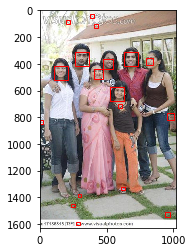

In [71]:
def plot_res(name, folder_pred, folder_dataset, threshold=0.999):
    print(folder_dataset)
    bb_pred, bb_truth = [], []
    folder_truth = "./dataset/truth_wider/modified/"
    with open(f"{folder_pred}{name}.txt", "r") as f:
        for l in f.readlines():
            prob, x1, y1, x2, y2 = list(map(float, l.split(" ")[1:]))
#             x2, y2 = x1 + w, y1 + h
            bb_pred.append([y1, x1, y2, x2])
    path_img = f"{folder_dataset}{name}.jpg"
    print(path_img)
    img = cv2.imread(path_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     bb_pred = non_max_suppression_fast(np.array(bb_pred), 0.5)
    plot_img_with_bb(img, bb_pred)
imgs_predicted = set(os.listdir(folder_predictions))
list(imgs_predicted)[0]
# Good: 3
plot_res(list(imgs_predicted)[31].replace(".txt", ""), folder_predictions, "./dataset/WIDER_val/images/"+folder2predict+"/")